# Analyse des données liées au COVID-19 en France

## Importation des modules

In [121]:
import pandas as pd 

In [122]:
import numpy as np 

In [123]:
import matplotlib.pyplot as plt 
%matplotlib inline

In [124]:
import requests

## Récupération du fichier .csv

In [125]:
# Récupération du fichier .csv à partir d'une URL stable
url = "https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7"

req = requests.get(url) # Envoi de la requête

if req.status_code == 200:
    print("LINK OK")
else:
    print(req.status_code)

url_content = req.content # Binary content
csv_file = open('cov.csv', 'wb')

csv_file.write(url_content)
csv_file.close()

cov = pd.read_csv('cov.csv', sep=";")

LINK OK


## Exploration des données

In [129]:
# Dimensions du dataset (lignes, colonnes)
cov.shape

(75750, 7)

In [126]:
# Affichage des premières lignes
cov.head()

,dep,sexe,jour,hosp,rea,rad,dc
0,01,0,2020-03-18,2,0,1,0
1,01,1,2020-03-18,1,0,1,0
2,01,2,2020-03-18,1,0,0,0
3,02,0,2020-03-18,41,10,18,11
4,02,1,2020-03-18,19,4,11,6


In [127]:
# Affichage des dernières lignes
cov.tail()

,dep,sexe,jour,hosp,rea,rad,dc
75745,974,1,2020-11-22,47,8,295,20
75746,974,2,2020-11-22,40,8,299,23
75747,976,0,2020-11-22,11,5,505,34
75748,976,1,2020-11-22,6,2,242,21
75749,976,2,2020-11-22,5,3,257,13


In [128]:
# Description générale du dataset
cov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75750 entries, 0 to 75749
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   dep     75750 non-null  object
 1   sexe    75750 non-null  int64 
 2   jour    75750 non-null  object
 3   hosp    75750 non-null  int64 
 4   rea     75750 non-null  int64 
 5   rad     75750 non-null  int64 
 6   dc      75750 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 4.0+ MB


Informations sur les colonnes :

dep = département (type 'str' et non 'int' car dep. Corse = 2A et 2B)

sexe = 0 : h/f | 1 : h | 2 : f

jour = date enregistrement

hosp = nombre d'hospitalisations

rea = nombre de patients en réanimation

rad = Nombre de personnes retournées à domicile

dc = Nombre de décès en milieu hospitalier


## Visualisation

### Tout le territoire

#### Réanimations

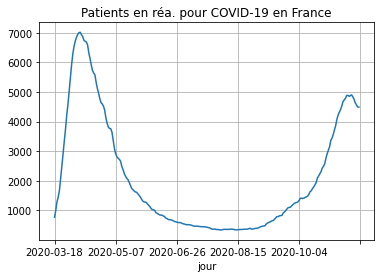

In [130]:
# Réanimations
cov_0 = cov.loc[cov['sexe'] == 0]
cov_rea = cov_0.groupby("jour").rea.sum()
rea_graph = cov_rea.plot(grid=True, title="Patients en réa. pour COVID-19 en France")
#249

In [131]:
# Variations jour
last = cov_rea[len(cov_rea)-1]
b_last = cov_rea[len(cov_rea)-2]
diff = last - b_last
perc = round(((last/b_last)*100)-100, 2)

if last > b_last:
    print(f"Variation journalière = +{diff} [{perc}%] (Auj. : {last}, hier : {b_last})")
else :
    print(f"Variation journalière = {diff} [{perc}%] (Auj. : {last}, hier : {b_last})")

# Variation semaine
last_week = []
b_last_week = []
i = len(cov_rea)-1

while i > (len(cov_rea)-1) - 7:
    last_week.append(cov_rea[i])
    i-=1

while i > (len(cov_rea)-1) - 14:
    b_last_week.append(cov_rea[i])
    i-=1

lw_sum = sum(last_week)
blw_sum = sum(b_last_week)
diff = lw_sum - blw_sum
perc = round(((lw_sum/blw_sum)*100)-100, 2)

if lw_sum > blw_sum:
    print(f"Variation hébomadaire = +{diff} [{perc}%] (Cette sem. : {lw_sum}, Sem. der. : {blw_sum})")
else:
    print(f"Variation hébomadaire = {diff} [{perc}%] (Sem. : {lw_sum}, Sem. der. : {blw_sum})")


Variation journalière = -2 [-0.04%] (Auj. : 4491, hier : 4493)
Variation hébomadaire = -1021 [-3.03%] (Sem. : 32687, Sem. der. : 33708)


#### Hospitalisations

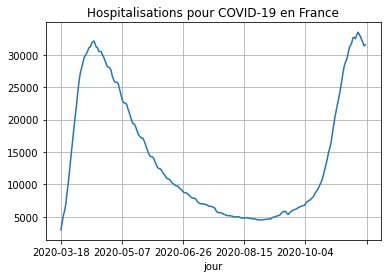

In [138]:
# Hospitalisations
hosp_cov = cov_0.groupby("jour").hosp.sum()
hosp_graph = hosp_cov.plot(grid=True, title="Hospitalisations pour COVID-19 en France")

#### Décès

<AxesSubplot:title={'center':'Nombre de décès par jour en milieu hospitalier\n suite à la COVID-19 en France'}>

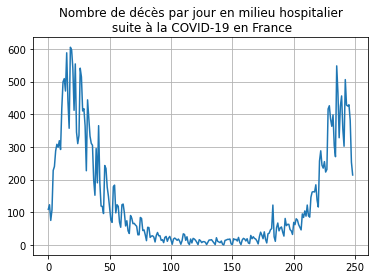

In [146]:
def ratio(x): # <list>

    i = 1
    loop = 0
    L = []

    while loop < len(x) - 1 :
        res = x[i] - x[i - 1]
        #res = abs(res)
        L.append(res)
        i += 1
        loop += 1

    L = pd.Series(L)

    return L #<list>

ratio(cov_dc).plot(grid = True, title="Nombre de décès par jour en milieu hospitalier\n suite à la COVID-19 en France")

<AxesSubplot:title={'center':'Nombre de décès cumulé en milieu hospitalier\n suite à la COVID-19 en France'}, xlabel='jour'>

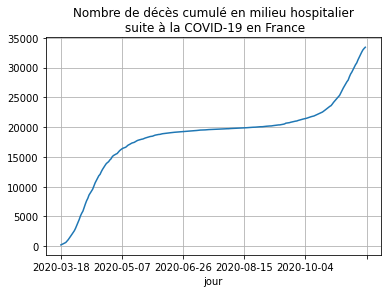

In [144]:
cov_dc = cov_0.groupby("jour").dc.sum()
cov_dc.plot(grid=True, title="Nombre de décès cumulé en milieu hospitalier\n suite à la COVID-19 en France")

#### Réanimations / Hospitalisations

<class 'matplotlib.axes._subplots.AxesSubplot'>


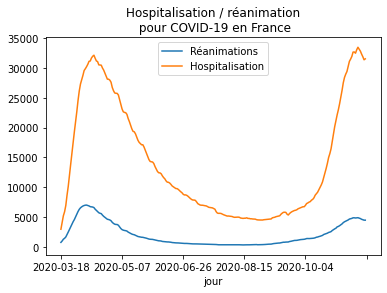

In [134]:
cov_rea.to_frame()
hosp_cov.to_frame()
rea_graph = cov_rea.plot(x="jour", y="rea")
hosp_graph = hosp_cov.plot(x="jour", y="hosp", title="Hospitalisation / réanimation\n pour COVID-19 en France")
hosp_graph.legend(["Réanimations", "Hospitalisation"])
print(type(hosp_graph))

<AxesSubplot:title={'center':'Variation réa.'}>

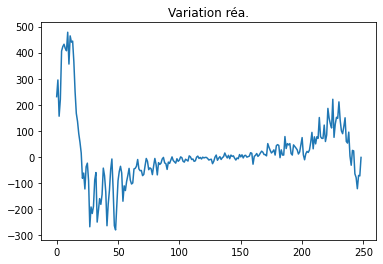

In [147]:
def ratio(x): # <list>

    i = 1
    loop = 0
    L = []

    while loop < len(x) - 1 :
        res = x[i] - x[i - 1]
        #res = abs(res)
        L.append(res)
        i += 1
        loop += 1

    L = pd.Series(L)

    return L #<list>

#cov_rea_list = list(cov_rea)
out = ratio(cov_rea)
out_2 = ratio(hosp_cov)

out.plot(title = "Variation réa.")
#out_2.plot()

### Par département

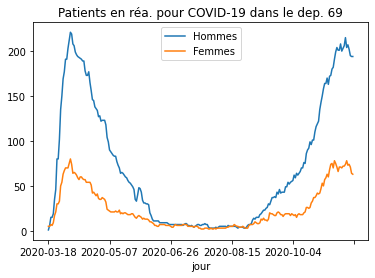

In [136]:
dep = "69" # Changer le département
cov_dep = cov.loc[cov['dep'] == dep]

cov_dep_0 = cov_dep.loc[cov_dep['sexe'] == 0] # Just H/F
cov_dep_1 = cov_dep.loc[cov_dep['sexe'] == 1] # Just H
cov_dep_2 = cov_dep.loc[cov_dep['sexe'] == 2] # Just F

title = f"Patients en réa. pour COVID-19 dans le dep. {dep}"

rea_1 = cov_dep_1.plot(x="jour", y="rea")
rea_2 = cov_dep_2.plot(x="jour", y="rea", ax=rea_1, grid=False, title = title)
rea_2.legend(["Hommes", "Femmes"])

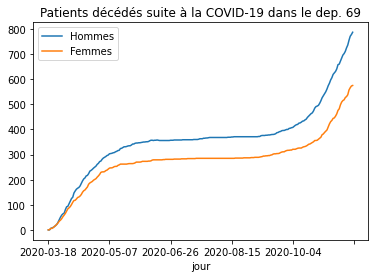

In [137]:
dep = "69"

cov_dep = cov.loc[cov['dep'] == dep]

cov_dep_0 = cov_dep.loc[cov_dep['sexe'] == 0] # Just H/F
cov_dep_1 = cov_dep.loc[cov_dep['sexe'] == 1] # Just H
cov_dep_2 = cov_dep.loc[cov_dep['sexe'] == 2] # Just F

title = f"Patients décédés suite à la COVID-19 dans le dep. {dep}"

dc_1 = cov_dep_1.plot(x="jour", y="dc")
dc_2 = cov_dep_2.plot(x="jour", y="dc", ax=dc_1, grid=False, title = title)
dc_2.legend(["Hommes", "Femmes"])